In [253]:
import sys
sys.path.insert(0,'C:\\Coding\\Local_repositories\\Exammmmm\\')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

import seaborn as sns
sns.set_theme()

from codelib.visualization.base import fan_chart

# The Cox-Ingersoll-Ross model

In [254]:
# 

r_0 = 0.02
kappa = 0.36
theta = 0.08
beta = 0.1
weeks_per_year = 52
years = 10

weeks_total = weeks_per_year * years
delta_t = 1 / weeks_per_year # Weekly time steps

num_sim = 10000

# Simulating standard normal random variables
dz = np.random.normal(loc = 0, scale = np.sqrt(delta_t), size = (num_sim, weeks_total))

In [255]:
# Short rate loop

short_rate = np.empty(shape = (num_sim, weeks_total + 1))

for i in range(weeks_total + 1):
    if i == 0:
        short_rate[:, i] = r_0
    else:
        short_rate[:, i] = short_rate[:, i - 1] + kappa * (theta - short_rate[:, i - 1]) * delta_t + beta * np.sqrt(short_rate[:, i - 1]) * dz[:, i - 1]

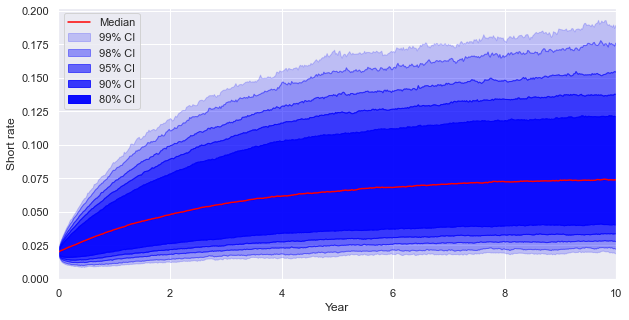

In [256]:
# Plot of short rate

x = np.linspace(0, 10, weeks_total + 1)

percentiles_CIR = np.percentile(short_rate, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5], axis = 0)

fig, ax = plt.subplots(figsize=(10, 5))

fan_chart(x,
          percentiles_CIR,
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax = ax)

ax.set_xlabel("Year")
ax.set_ylabel("Short rate")
ax.set_xlim(0, 10)
ax.legend(loc='upper left');

In [257]:
# Test of mean and variance of short rate at year 10

def expected_CIR_shortrate(theta, r_t, kappa, t, s):
    return theta + (r_t - theta) * np.exp(-kappa * (s - t))

def var_CIR_shortrate(beta, r_t, kappa, t, s):
    return ((beta**2 * r_t) / kappa) * (np.exp(-kappa * (s - t)) - np.exp(-2 * kappa * (s - t))) + ((beta ** 2 * theta) / (2 * kappa)) * (1 - np.exp(-kappa * (s - t))) ** 2


In [258]:
# Expected value

print("Expected CIR short rate at year 10: " + str(expected_CIR_shortrate(theta, r_0, kappa, 0, 10)))
print("Simulated CIR short rate mean at year 10: " + str(short_rate[:, -1].mean()))

Expected CIR short rate at year 10: 0.07836057665316244
Simulated CIR short rate mean at year 10: 0.07851217844870831


In [259]:
# Mean

print("Variance CIR short rate at year 10: " + str(var_CIR_shortrate(beta, r_0, kappa, 0, 10)))
print("Simulated CIR short rate variance at year 10: " + str(short_rate[:, -1].var(ddof = 1)))

Variance CIR short rate at year 10: 0.0010659863435924998
Simulated CIR short rate variance at year 10: 0.001068101874448593


In [260]:
# Calculating zero-coupon bond prices with face value 1 using the CIR-model

def ZCB_t(t, T, r_t, kappa_hat, theta_hat, beta, price = False):
    
    """Calculates price or yield of a ZCB at time t with TTM = T - t using the CIR short rate model."""
    
    gamma = np.sqrt(kappa_hat ** 2 + 2 * beta ** 2)
    a = -((2 * kappa_hat * theta_hat) / beta ** 2) * (np.log(2 * gamma) + 0.5 * (kappa_hat + gamma) * (T - t) - np.log((gamma + kappa_hat) * (np.exp(gamma * (T - t)) - 1) + 2 * gamma))
    b = (2 * (np.exp(gamma * (T - t)) - 1)) / ((gamma + kappa_hat) * (np.exp(gamma * (T - t)) - 1) + 2 * gamma)
    if price == True:
        return 1 * np.exp(-a - b * r_t)
    if price == False:
        ZCB_price = np.exp(-a - b * r_t)
        return (1 / (T - t)) * np.log(1 / ZCB_price)

In [261]:
# Creating zero coupon yields

lambd = 0
kappa_hat = kappa + lambd
theta_hat = (kappa * theta) / (kappa + lambd)

T = np.linspace(0.1, 10, 100)

ZCB_yield = np.empty(shape = 100)
ZCB_price = np.empty(shape = 100)

for i, j in zip(T, range(100)):
    ZCB_yield[j] = ZCB_t(0, i, r_0, kappa_hat, theta_hat, beta) 
    ZCB_price[j] = ZCB_t(0, i, r_0, kappa_hat, theta_hat, beta, price = True) 

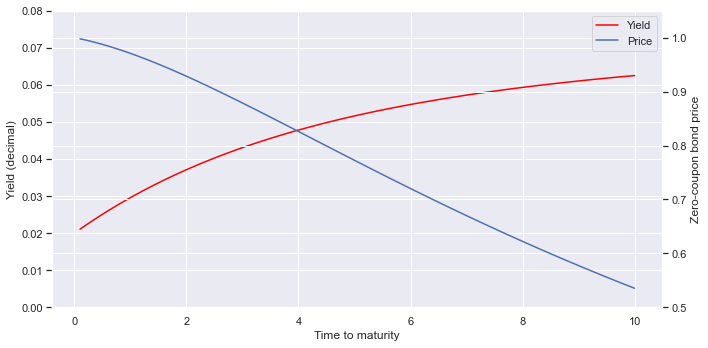

In [262]:
labels = ["Yield", "Price"]

fig, ax = plt.subplots(figsize = (10, 5))

yields = ax.plot(T, ZCB_yield, label = labels[0], color = "red")
ax.set_ylim(0, 0.08)

ax2 = ax.twinx()

prices = ax2.plot(T, ZCB_price, label = labels[1])
ax2.set_ylim(0.5, 1.05)

plt.legend(yields + prices, labels, loc = 0)
ax.set_xlabel("Time to maturity")
ax.set_ylabel("Yield (decimal)")
ax2.set_ylabel("Zero-coupon bond price")
fig.tight_layout()
plt.show()

In [263]:
# Loading cash flow data

data = pd.read_excel("C:\\Coding\\Local_repositories\\Exammmmm\\ExamData\\cashflow.xlsx", usecols = [0, 1])

# Calculating ZCB prices and yields for maturities 1, 2, ..., 10

ZCB_prices_1to10 = np.empty(shape = 10)
ZCB_yields_1to10 = np.empty(shape = 10) 

for i in range(10):
    ZCB_prices_1to10[i] = ZCB_t(0, i + 1, r_0, kappa_hat, theta_hat, beta, price = True)
    ZCB_yields_1to10[i] = ZCB_t(0, i + 1, r_0, kappa_hat, theta_hat, beta, price = False)

In [264]:
# Combining into one dataframe

cashflows_pd = pd.concat([data, pd.Series(ZCB_prices_1to10), pd.Series(ZCB_yields_1to10)], axis = 1).rename(columns = {"time (T)" : "Time", "cf" : "Cash flow", 0 : "ZCB price", 1 : "ZCB yield"})

# Calculating present values of cash flows using 1) ZCB prices and 2) ZCB yields

cashflows_pd["PV"] = cashflows_pd["Cash flow"] * cashflows_pd["ZCB price"]
cashflows_pd["PV2"] = cashflows_pd["Cash flow"] * np.exp(-cashflows_pd["ZCB yield"] * cashflows_pd["Time"])

# Total present value of cash flows

PV_total = cashflows_pd["PV"].sum()

# Show 
PV_total

5113621.302359084

In [265]:
cashflows_pd

,Time,Cash flow,ZCB price,ZCB yield,PV,PV2
0,1,1000000,0.970853,0.029580,970852.901947,970852.901947
1,2,900000,0.928471,0.037108,835623.835683,835623.835683
2,3,800000,0.878812,0.043061,703049.940614,703049.940614
3,4,700000,0.825952,0.047805,578166.677854,578166.677854
4,5,600000,0.772537,0.051615,463522.251964,463522.251964
5,6,500000,0.720205,0.054703,360102.723785,360102.723785
6,7,500000,0.669918,0.057228,334959.194315,334959.194315
7,8,500000,0.622195,0.059313,311097.480078,311097.480078
8,9,500000,0.577274,0.061049,288636.810380,288636.810380
9,10,500000,0.535219,0.062508,267609.485740,267609.485740


In [266]:
cf_weeks = np.empty_like(short_rate)
cf_cum_weeks = np.empty_like(short_rate)

weeks = np.linspace(53, 521, 10, dtype = int)
cfs = list(cashflows_pd["Cash flow"])

In [663]:
def ZCB_t(tau, r_t, kappa_hat, theta_hat, beta, price = False):
    
    """Calculates price or yield of a ZCB at time t with TTM = T - t using the CIR short rate model."""
    
    gamma = np.sqrt(kappa_hat ** 2 + 2 * beta ** 2)
    a = -((2 * kappa_hat * theta_hat) / beta ** 2) * (np.log(2 * gamma) + 0.5 * (kappa_hat + gamma) * tau - np.log((gamma + kappa_hat) * (np.exp(gamma * tau) - 1) + 2 * gamma))
    b = (2 * (np.exp(gamma * tau) - 1)) / ((gamma + kappa_hat) * (np.exp(gamma * tau) - 1) + 2 * gamma)
    if price == True:
        return 1 * np.exp(-a - b * r_t)
    if price == False:
        ZCB_price = np.exp(-a - b * r_t)
        return (1 / tau) * np.log(1 / ZCB_price)

In [664]:
# Creating cash flow array

acc_cf = cashflows_pd["Cash flow"].cumsum()

for i, j, k in zip(weeks, cfs, acc_cf):
    cf_weeks[:, (i - 1):] = j
    cf_cum_weeks[:, (i - 1):] = k

In [665]:
sr

array([0.02      , 0.02061521, 0.02058488, 0.02288199, 0.02642895,
       0.02489113, 0.02868517, 0.02933236, 0.02678146, 0.02557785,
       0.02294317, 0.02228076, 0.02166012, 0.02006937, 0.01861488,
       0.02057693, 0.01838689, 0.01852832, 0.01938328, 0.02023655,
       0.02139719, 0.02357398, 0.0235384 , 0.02347764, 0.02598958,
       0.02727306, 0.02998972, 0.03085836, 0.03475745, 0.04028674,
       0.04019585, 0.03741877, 0.03231615, 0.03167304, 0.02983882,
       0.03114255, 0.03068724, 0.03197752, 0.03159064, 0.02965541,
       0.02731409, 0.02790701, 0.03047442, 0.02877917, 0.02989159,
       0.03318416, 0.03553927, 0.03777053, 0.0392672 , 0.042732  ,
       0.04430996, 0.04644968, 0.04628167, 0.04488488, 0.04779872,
       0.04330943, 0.04314552, 0.03824091, 0.03784937, 0.04194779,
       0.04250375, 0.04252734, 0.04069542, 0.03909653, 0.0429896 ,
       0.04217327, 0.04176106, 0.04223336, 0.04110646, 0.04132721,
       0.03772945, 0.03468103, 0.03949694, 0.04342297, 0.04495

In [745]:
tau = dict()

for i in range(1, 11):
    if i == 1:
        np.linspace(0, 1, 53)
    else:
        tau[i] = np.linspace(1/52, 1, 52) + i

In [746]:
tau

{2: array([2.01923077, 2.03846154, 2.05769231, 2.07692308, 2.09615385,
        2.11538462, 2.13461538, 2.15384615, 2.17307692, 2.19230769,
        2.21153846, 2.23076923, 2.25      , 2.26923077, 2.28846154,
        2.30769231, 2.32692308, 2.34615385, 2.36538462, 2.38461538,
        2.40384615, 2.42307692, 2.44230769, 2.46153846, 2.48076923,
        2.5       , 2.51923077, 2.53846154, 2.55769231, 2.57692308,
        2.59615385, 2.61538462, 2.63461538, 2.65384615, 2.67307692,
        2.69230769, 2.71153846, 2.73076923, 2.75      , 2.76923077,
        2.78846154, 2.80769231, 2.82692308, 2.84615385, 2.86538462,
        2.88461538, 2.90384615, 2.92307692, 2.94230769, 2.96153846,
        2.98076923, 3.        ]),
 3: array([3.01923077, 3.03846154, 3.05769231, 3.07692308, 3.09615385,
        3.11538462, 3.13461538, 3.15384615, 3.17307692, 3.19230769,
        3.21153846, 3.23076923, 3.25      , 3.26923077, 3.28846154,
        3.30769231, 3.32692308, 3.34615385, 3.36538462, 3.38461538,
        

In [731]:
sr = np.flip(short_rate[0])

PV_future_cf = np.empty(shape = short_rate.shape[1])

for j in range(weeks[8], weeks[9]):
    PV_future_cf[j] += ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[0]

    

IndexError: index 469 is out of bounds for axis 0 with size 53

In [728]:
PV_future_cf.shape

(521,)

In [729]:
np.set_printoptions(suppress=True)
print(PV_future_cf)

[ 251517.27003302  252034.27294331  251201.73335893  250338.45076936
  249229.98362835  247022.03616724  244439.64049689  246349.12571276
  245810.28429093  248734.95015244  248585.43947896  249819.01015765
  246180.29628549  245520.21161033  245824.14476345  243400.71379966
  247133.19274808  250825.7144286   253206.92131171  252958.9246312
  255326.28020282  257505.90867326  257216.34868724  259523.65942476
  262642.51912903  261876.84543024  264790.93065481  264807.72678911
  264198.57743132  265798.09262277  265967.79637097  261301.66781264
  261854.54163528  261363.00807533  260263.51890961  261248.84037903
  262181.09762457  261548.64365381  260989.39023803  263661.02680882
  265653.0248963   264228.66437198  262112.36072746  261241.80204316
  258955.34418064  259852.1815584   262368.44048593  262548.44021149
  260828.68824229  260798.96614306  257949.94936445  263078.62735652
  264376.30580339  265310.17065464  263190.58443902  261667.22449652
  261287.79915625  263182.52707719 

In [434]:

for j in range(weeks[7], weeks[8], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[8]
    
for j in range(weeks[6], weeks[7], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[7]
    
for j in range(weeks[5], weeks[6], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[6]
    
for j in range(weeks[4], weeks[5], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[5]
    
for j in range(weeks[3], weeks[4], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[4]
    
for j in range(weeks[2], weeks[3], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[3]
    
for j in range(weeks[1], weeks[2], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[2]

for j in range(weeks[0], weeks[1], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[1]
    
for j in range(weeks[0], -1):
    PV_future_cf[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[0]

In [435]:
PV_future_cf

array([4.94065646e-324, 6.95249733e-310, 2.02369289e-320,             nan,
       2.52961611e-321, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1.07908536e-311, 1.07908536e-311, 1.07908536e-311,
       1.07908536e-311, 1

In [272]:
TTM[-1]

0.019230769230769232

In [424]:
hej = np.empty(521)

for j in range(weeks[9], weeks[8]):
    hej[j] = ZCB_t(tau[j], sr[j], kappa_hat, theta_hat, beta, price = True) * cfs[9]

In [426]:
weeks[9]

521